In [1]:
import os,sys
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

os.environ['PYTHONPATH']=os.environ.get('LIB')
if not os.environ.get('LIB') in sys.path: 
    sys.path.insert(0,os.environ.get('LIB'))

INP_DIR = os.environ.get('DAT_DIR')    
FIG_DIR = os.environ.get('FIG_DIR')

%load_ext autoreload
%autoreload 2
%pylab inline
%load_ext rpy2.ipython

import matplotlib.text as text
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys
import rpy2 
import os 
from matplotlib import gridspec
from scipy.interpolate import splev, splrep
import seaborn as sns
from scipy import stats
import rpy2.robjects.packages as rpackages
import seaborn as sns
from statsmodels import robust
from box import Box


pd.set_option('display.max_colwidth', 500)




Populating the interactive namespace from numpy and matplotlib


# Goal

Figure out how to call tcplfit2 and tcplhit2

# tcplfit2

In [3]:
%%R

library(tcpl)
.libPaths()


[1] "/opt/miniconda3/lib/R/library"


In [9]:
CR = pd.DataFrame(dict(lconc=[1,10,20,50,90,100], resp=[0.1,0.4,1,5,10,12]))
CR

,lconc,resp
0,1,0.1
1,10,0.4
2,20,1.0
3,50,5.0
4,90,10.0
5,100,12.0


In [10]:
%Rpush CR

In [48]:
%%R

library(tcpl)
RFit <- tcplFit(CR$lconc,CR$resp,bmad=1)
RFit


R[write to console]: tcpl (v2.0.2) loaded with the following settings:
  TCPL_DB:    /opt/miniconda3/lib/R/library/tcpl/csv
  TCPL_USER:  NA
  TCPL_HOST:  NA
  TCPL_DRVR:  tcplLite
Default settings stored in tcpl config file. See ?tcplConf for more information.

R[write to console]: Error in tapply(resp, logc, mean) : object 'CR' not found




Error in tapply(resp, logc, mean) : object 'CR' not found


In [49]:
%%R 

?tcplfit2_core

File: /tmp/Rtmp4dIPAr/Rtxt4065111fa0b5
tcplfit2_core             package:tcplfit2             R Documentation



Concentration-response curve fitting



Description:



     Concentration response curve fitting using the methods from

     BMDExpress



Usage:



     tcplfit2_core(

       conc,

       resp,

       cutoff,

       force.fit = FALSE,

       bidirectional = TRUE,

       verbose = FALSE,

       do.plot = FALSE,

       fitmodels = c("cnst", "hill", "gnls", "poly1", "poly2", "pow", "exp2", "exp3", "exp4",

         "exp5"),

       ...

     )

     

Arguments:



    conc: Vector of concentrations (NOT in log units).



    resp: Vector of responses.



  cutoff: Desired cutoff. If no absolute responses > cutoff and

          force.fit = F, will only fit constant model.



force.fit: If force.fit = T, will fit all models regardless of cutoff.



bidirectional: If bidirectional = F, will only give positive fits.



 verbose: If verbose = T, will print optimization 

In [96]:
%%R

library(tcplfit2)
RFit <- tcplfit2_core(c(1,10,20,50,90,100),c(0,0.4,1,5,10,12),CR$resp,cutoff=1,verbose=T,bidirectional=T)
names(RFit)
RFit$hill

hill >>> 1877 0 
gnls >>> 3651 0 
poly1 >>> 77 0 
poly2 >>> 414 0 
power >>> 876 0 
Exp2 >>> 196 0 
Exp3 >>> 555 0 
Exp4 >>> 324 0 
Exp5 >>> 1367 0 
[1] "aic values:"
     cnst      hill      gnls     poly1     poly2       pow      exp2      exp3 
42.143221 14.781261 18.781259 17.784846  7.125681  7.005693 10.561616  7.983150 
     exp4      exp5 
28.192109 10.449058 
Winner:  pow$success
[1] 1

$aic
[1] 14.78126

$cov
[1] 1

$rme
[1] 0.478473

$modl
[1] 4.546982e-04 1.413709e-01 7.632010e-01 5.118664e+00 1.015594e+01
[6] 1.089897e+01

$tp
[1] 14.4

$ga
[1] 63.45701

$p
[1] 2.496908

$er
[1] -1.238223

$tp_sd
[1] 1.137298

$ga_sd
[1] 4.520976

$p_sd
[1] 0.2775614

$er_sd
[1] 0.5571156

$pars
[1] "tp" "ga" "p"  "er"

$sds
[1] "tp_sd" "ga_sd" "p_sd"  "er_sd"

$top
[1] 14.4

$ac50
[1] 63.45701



In [38]:
%%R

#?tcplfit2_core
RFit$modelnames

 [1] "cnst"  "hill"  "gnls"  "poly1" "poly2" "pow"   "exp2"  "exp3"  "exp4" 
[10] "exp5" 


In [4]:
from tcpl.fit.tcplfit import *

F = tcplFit2(CR.lconc,CR.resp,cutoff=1)

In [125]:
F['best_fit']

'pow'

In [7]:
[i['model'] for i in F['fits']]

['cnst',
 'hill',
 'gnls',
 'poly1',
 'poly2',
 'pow',
 'exp2',
 'exp3',
 'exp4',
 'exp5']

In [13]:
from tcpl.fit.tcplfit import *

for M in F['fits']:
    print(M['model'])
    if M['model']=='cnst': continue
    P = M['params']
    P['x']=200
    print(eval("{model}F(**P)".format(**M)))

cnst
hill
13.6364274572373
gnls
13.636549696731329
poly1
22.51767879695921
poly2
41.323175655840096
pow
31.179636972849444
exp2
44.18753771060069
exp3
41.64218895608892
exp4
13.003163235500235
exp5
14.37728259908976


cnst
hill
gnls
poly1
poly2
pow
exp2
exp3
exp4
exp5


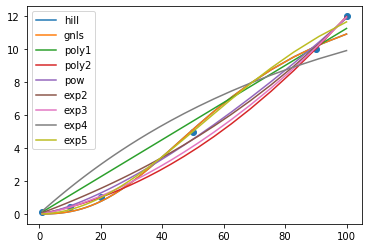

In [27]:
from tcpl.fit.tcplfit import *

D0 = pd.DataFrame(F['cr_data'])
pl.scatter(D0.conc,D0.resp)
for M in F['fits']:
    print(M['model'])
    if M['model']=='cnst': continue
    P = M['params']

    CRi = []
    for x in 10**np.linspace(0,2):
        P['x']=x
        r=eval("{model}F(**P)".format(**M))
        CRi.append(dict(c=x,r=r))
    Y = pd.DataFrame(CRi)
    pl.plot(Y.c,Y.r,label=M['model'])
pl.legend()

In [26]:
def calc_BMD1(Fit,BMR=[1,2,3],C=None,
              ret='dict',add_info=False,
              dbg=False):
  """
  Calculate benchmark doses corresponding to bmrs
  """
  #LC = np.log10(C)
  ci,cf = C.min(),C.max()

  BMD=[]
  P = Fit['params']
  
  for bmr in BMR:
    def bmdf(c): 
        P['x']=c
        return eval("{model}F(**P)".format(**Fit)) - bmr
    
    soln = optz.fsolve(bmdf,[ci,cf])
    soln = soln[np.logical_and(soln>ci,soln<cf)]
    bmd0 = np.min(soln)

    BMD.append(bmd0)
    
  return BMD
  

In [47]:
from tcpl.fit.tcplfit import *

calc_BMDs(F['fits'][2],C=np.array([0.5,200]),dbg=True)


Failed E 1.00
Failed E 2.00
Failed E 3.00


/home/ishah/ipynb/chiron/tcplpy/src/tcpl/fit/tcplfit.py:156: RuntimeWarning: invalid value encountered in power
  return tp/((1 + (ga/x)**p )*(1 + (x/la)**q))


[]

In [40]:
F['fits'][2]

{'model': 'gnls',
 'aic': 18.92046942340897,
 'top': 14.395353463983058,
 'ac50': 63.37108243335995,
 'params': {'tp': 14.399999999985656,
  'ga': 63.387386281144714,
  'p': 2.5087286938418543,
  'la': 9999.349071784494,
  'q': 5.389231554969999,
  'er': -1.1952950937997588,
  'x': array([6.90341779e-310, 4.65868769e-310])},
 'param_sds': {'tp_sd': 1.2326875826018762,
  'ga_sd': 4.862534777621208,
  'p_sd': 0.29437713203253874,
  'la_sd': 313664996.0106442,
  'q_sd': 37181.685508674804,
  'er_sd': 0.5305768930394421},
 'resp_fit': [0.00043412336116826984,
  0.13872375758750594,
  0.7553651718168842,
  5.118454565813862,
  10.176514278218596,
  10.920472434120917]}

# tcplhit2

In [7]:
%%R

?tcplhit2_core

File: /tmp/RtmpaM6oOo/Rtxt131d1485285c
tcplhit2_core             package:tcplfit2             R Documentation



Hitcalling Function



Description:



     Core of hitcalling function. This method chooses the winning model

     from tcplfit2_core, extracts the top and ac50, computes the

     hitcall, and calculates bmd/bmdl/bmdu among other statistics.

     Nested model selection is used to choose between poly1/poly2, then

     the model with the lowest AIC (or AICc) is declared the winner.

     Continuous hitcalls requires tcplfit2_core to be run with

     force.fit = T and "cnst" never to be chosen as the winner.



Usage:



     tcplhit2_core(

       params,

       conc,

       resp,

       cutoff,

       onesd,

       bmed = 0,

       conthits = T,

       aicc = F,

       identifiers = NULL

     )

     

Arguments:



  params: The output from tcplfit2_core



    conc: list of concentrations (not in log units)



    resp: list of corresponding responses



  cu

In [13]:
CR

,lconc,resp
0,1,0.1
1,10,0.4
2,20,1.0
3,50,5.0
4,90,10.0
5,100,12.0


In [19]:
%%R

library(tcplfit2)
RFit <- tcplfit2_core(CR$lconc,CR$resp,cutoff=1,verbose=T,bidirectional=T)
RHit <- tcplhit2_core(RFit,CR$lconc,CR$resp,cutoff=1,onesd=1)
#names(RFit)
#RFit$hill
names(RHit)

hill >>> 1063 0 
gnls >>> 1562 0 
poly1 >>> 79 0 
poly2 >>> 368 0 
power >>> 608 0 
Exp2 >>> 134 0 
Exp3 >>> 503 0 
Exp4 >>> 376 0 
Exp5 >>> 1405 0 
[1] "aic values:"
     cnst      hill      gnls     poly1     poly2       pow      exp2      exp3 
42.143649 14.920470 18.920469 17.746439  8.352483  7.168116 10.503060  9.823740 
     exp4      exp5 
28.175043 10.623620 
Winner:  pow [1] "n_gt_cutoff"     "cutoff"          "fit_method"      "top_over_cutoff"
 [5] "rmse"            "a"               "b"               "tp"             
 [9] "p"               "q"               "ga"              "la"             
[13] "er"              "bmr"             "bmdl"            "bmdu"           
[17] "caikwt"          "mll"             "hitcall"         "ac50"           
[21] "ac50_loss"       "top"             "ac5"             "ac10"           
[25] "ac20"            "acc"             "ac1sd"           "bmd"            
[29] "conc"            "resp"           


In [30]:
%%R

RHit$bmr
unlist(RHit)

           n_gt_cutoff                 cutoff             fit_method 
                   "3"                    "1"                  "pow" 
       top_over_cutoff                   rmse                      a 
    "11.8846497214281"     "0.25421875834573"   "0.0195874044501253" 
                     b                     tp                      p 
                    NA                     NA     "1.39150474763515" 
                     q                     ga                     la 
                    NA                     NA                     NA 
                    er                    bmr                   bmdl 
    "-1.5175935175698"                "1.349"     "20.5437277575228" 
                  bmdu                 caikwt                    mll 
     "21.365730420987" "2.54190663754655e-08"   "-0.584058239377759" 
               hitcall                   ac50              ac50_loss 
   "0.999999974580934"     "60.7667277953441"                     NA 
                   t

In [28]:
tcplhit2

R object with classes: ('function',) mapped to: